import all libraries required 


In [0]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import time
import os
import copy

Mounting drive to notebook and using the dataset from there.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting Hyperparameters to train the network.


In [0]:
#set data directory 
data_dir = "/content/drive/My Drive/caltech101/train"

# set model to alexnet
model_name='alexnet'

# Number of classes in the dataset
num_classes = 30

# Batch size for training 
batch_size = 24

# Number of epochs to train for 
num_epochs = 10

Using GPU for training.

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Normalize and preprocess images in the dataset to match the network requirements.

In [0]:
normalize =  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [0]:
resize = transforms . Resize ((224 , 224) )

In [0]:
preprocessor = transforms .Compose ([ resize , transforms . ToTensor () , normalize , ])


Convert dataset images into pytorch ImageFolder format.

In [0]:
dataset=datasets.ImageFolder(data_dir,transform=preprocessor)

Define training function.

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Download the pretrained alexnet model and set the last layer to have 30 output classes. 

In [0]:
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,30)
input_size = 224

In [28]:
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
image_datasets = {x: dataset for x in ['train', 'val']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [30]:
# Send the model to GPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
for name,param in model_ft.named_parameters():
  if param.requires_grad == True:
    print("\t",name)

#Larger rate for the last layer
optimizer_ft = optim.SGD([{'params': model_ft.classifier[6].parameters(), 'lr':0.01}], lr=0.001, momentum=0.9)

	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


Train the model for 10 iterations.

In [31]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.3000 Acc: 0.7500
val Loss: 0.1890 Acc: 0.9620

Epoch 1/9
----------
train Loss: 0.4920 Acc: 0.9167
val Loss: 0.0428 Acc: 0.9847

Epoch 2/9
----------
train Loss: 0.1943 Acc: 0.9580
val Loss: 0.0618 Acc: 0.9900

Epoch 3/9
----------
train Loss: 0.1340 Acc: 0.9720
val Loss: 0.0140 Acc: 0.9960

Epoch 4/9
----------
train Loss: 0.0700 Acc: 0.9840
val Loss: 0.0049 Acc: 0.9987

Epoch 5/9
----------
train Loss: 0.0833 Acc: 0.9793
val Loss: 0.0038 Acc: 0.9987

Epoch 6/9
----------
train Loss: 0.0384 Acc: 0.9940
val Loss: 0.0016 Acc: 0.9993

Epoch 7/9
----------
train Loss: 0.0227 Acc: 0.9913
val Loss: 0.0000 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0322 Acc: 0.9913
val Loss: 0.0002 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0289 Acc: 0.9913
val Loss: 0.0002 Acc: 1.0000

Training complete in 2m 48s
Best val Acc: 1.000000


Save the trained model

In [0]:
PATH = '/content/drive/My Drive/caltech101.finetune.pth'
torch.save(model_ft.state_dict(), PATH)

Load the test data using pythorch

In [0]:
test_dir = "/content/drive/My Drive/caltech101/test"
testset=datasets.ImageFolder(test_dir,transform=preprocessor)
testloader=torch . utils . data . DataLoader( testset , batch_size=4 , shuffle=True)

Test model accuracy on test data 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 1

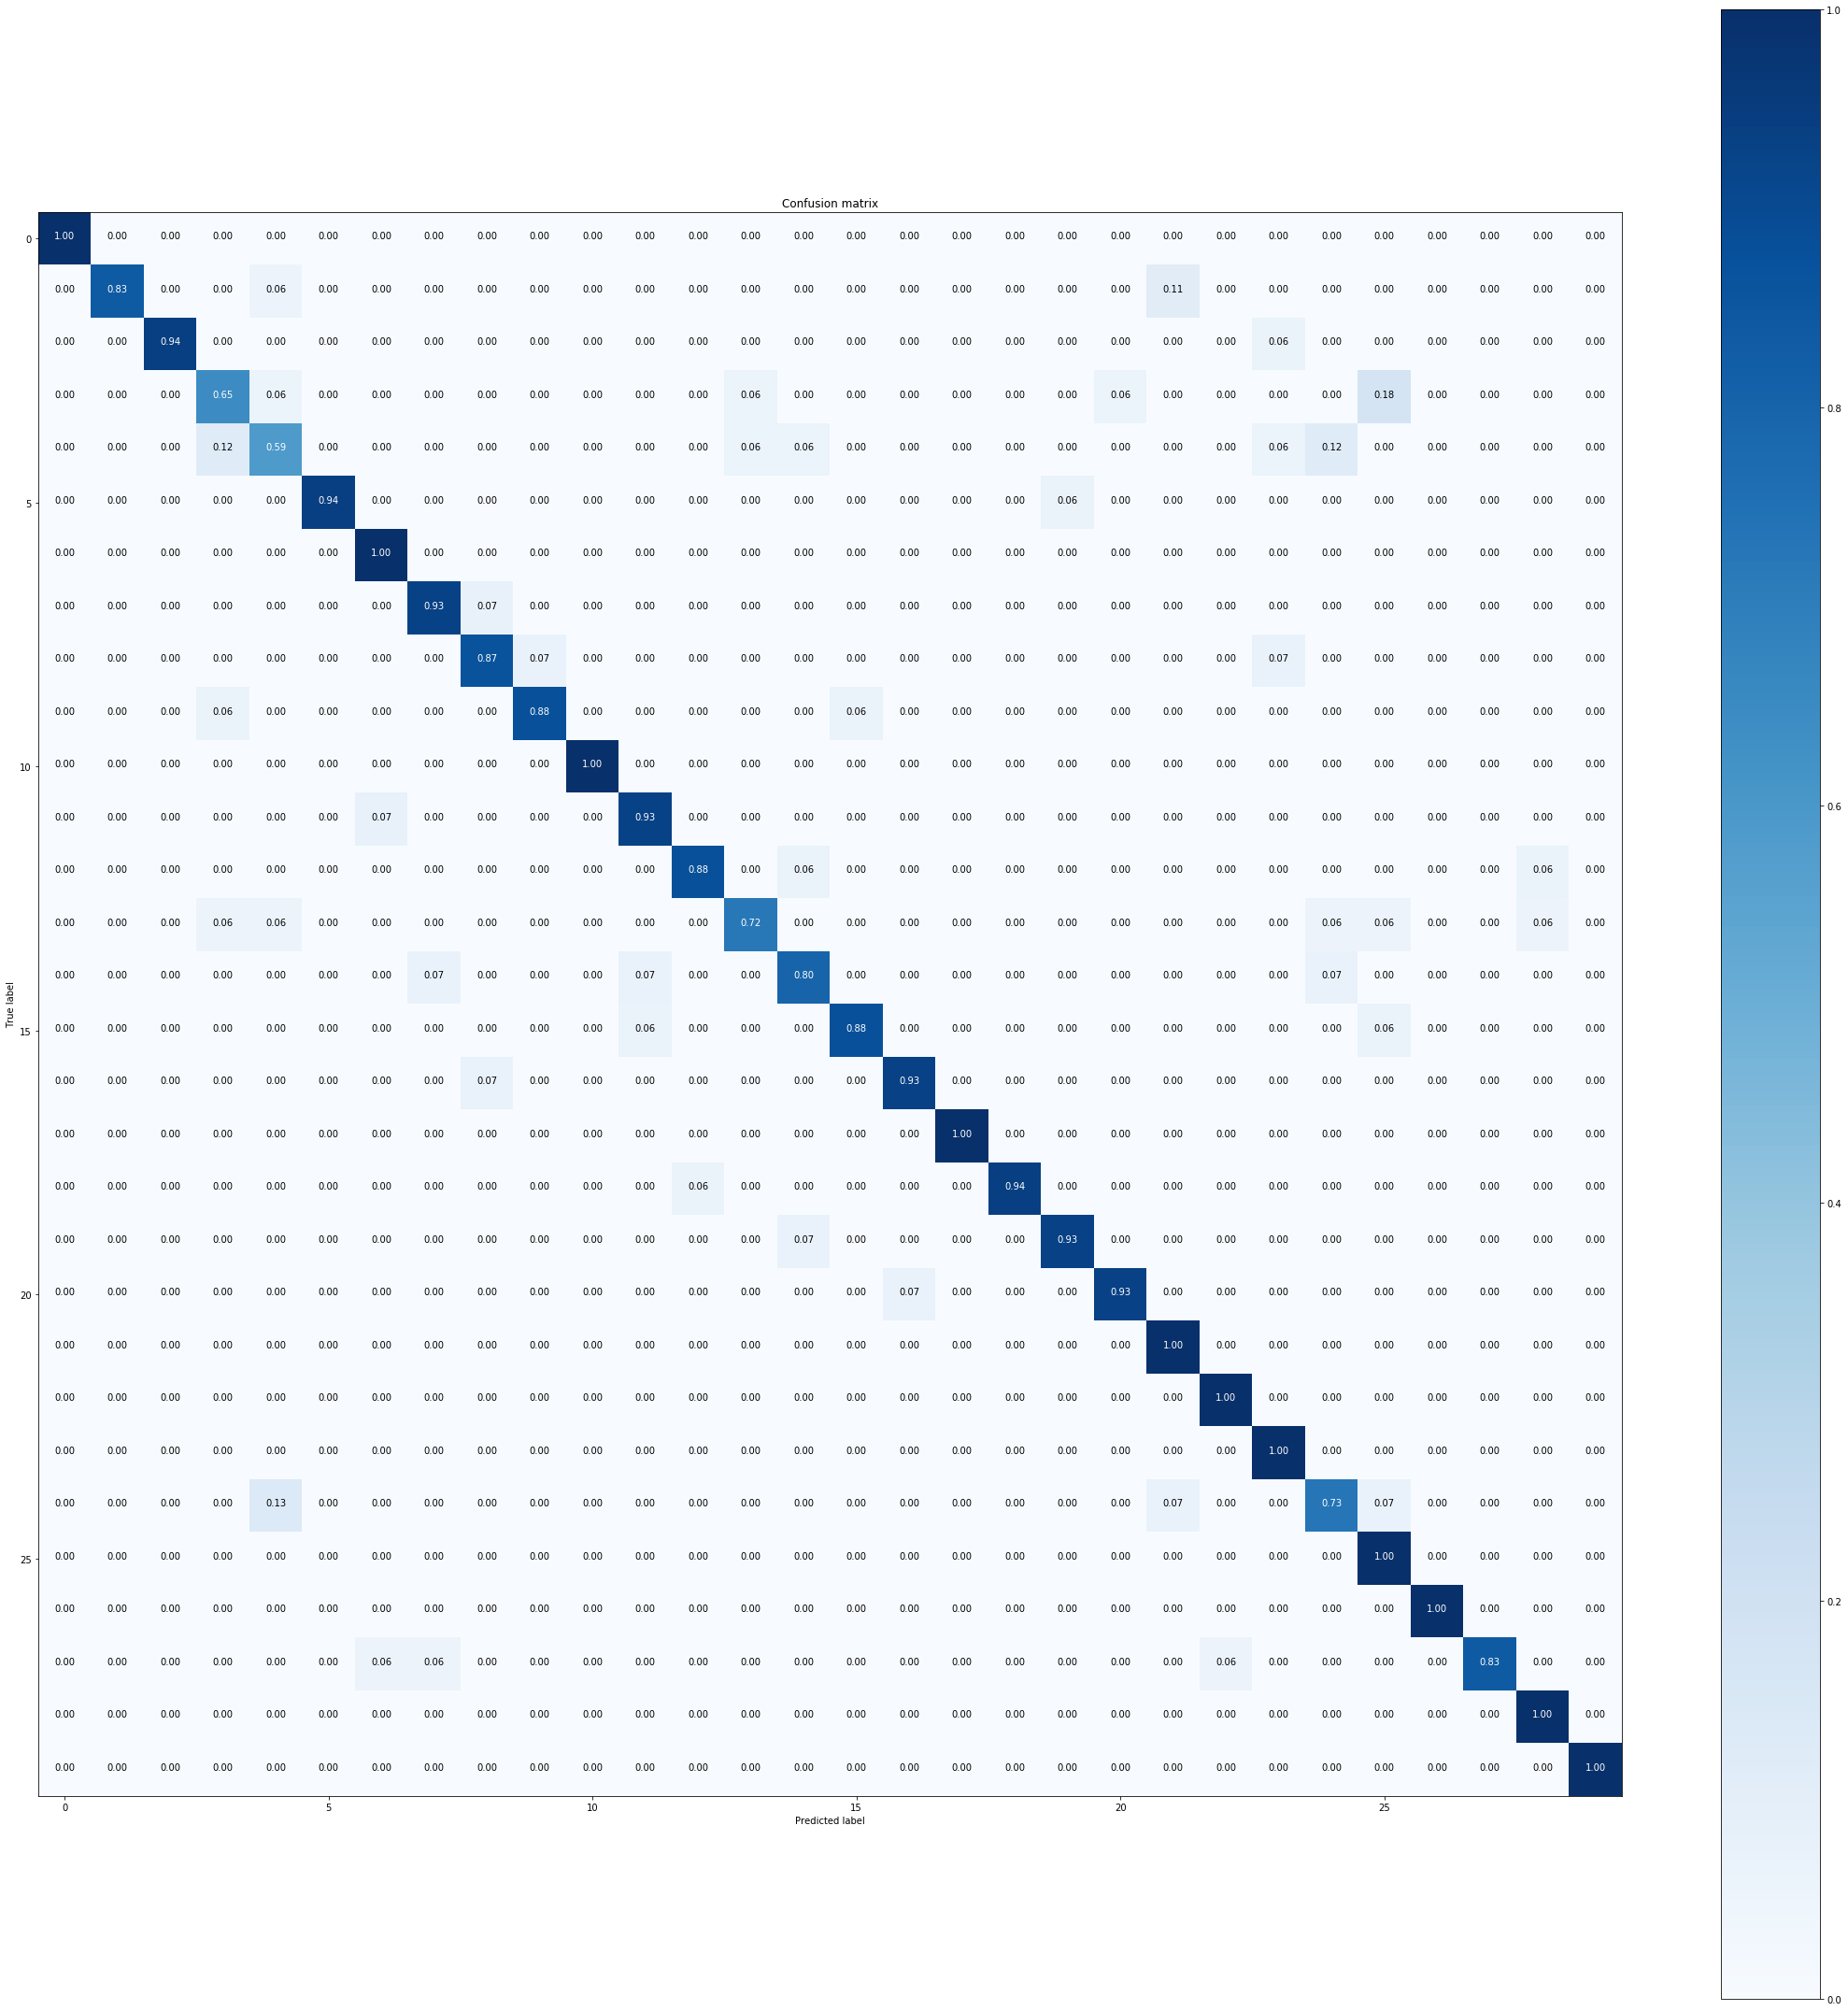

In [35]:
correct = 0
total = 0
test_labels = testloader.dataset.targets
print(test_labels)
correct = 0
total = 0
confusion_matrix = torch.zeros(30, 30)
labels_list=[]
predicts_list=[]
all_predicted=[]
t=0
p=0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        labels_list+=labels.cpu().numpy().tolist()
        all_predicted += predicted.cpu().numpy().tolist()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(pred_class, actual_class,
                          title='Confusion matrix',
                          size=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Code from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(actual_class, pred_class)



    cmap = plt.cm.Blues
    cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
    cm = np.nan_to_num(cm)

    if cm is not None:
        cm = cm[0:size, 0:size]

    print('Confusion matrix')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#testloader=torch . utils . data . DataLoader( testset , batch_size=4 , shuffle=True)
#net1 = FullNet()
#net1.fit(trainloader)
pred_labels =all_predicted# p.long()#net1.predict(testloader)
plt.figure(figsize=(30,30))

print(len(labels_list),len(pred_labels))

test_labels = labels_list#t.long()#testloader.dataset.targets
plot_confusion_matrix(test_labels, pred_labels,size=len(pred_labels))
#plot_confusion_matrix(confusion_matrix,size=len(pred_labels))

